<a href="https://colab.research.google.com/github/GitAmitesh/SkinDiseaseClassificationCNN/blob/main/model_2_SequentialCNN_DualLayer_66.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
!fusermount -u drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!find "/content/drive" -type f -name "final_processed_ham_metadata.pkl"


In [ ]:
# Path to your .pkl file
file_path = "/content/drive/MyDrive/HAM10000/final_processed_ham_metadata.pkl"

# Load the DataFrame
df = pd.read_pickle(file_path)

# Check the result
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,lesion_type,lesion_type_idx,image_array
0,HAM_0006018,ISIC_0033486,bkl,histo,75.0,male,trunk,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2,"[[[0.62352943, 0.58431375, 0.61960787], [0.619..."
1,HAM_0000206,ISIC_0033925,mel,histo,65.0,female,upper extremity,/content/drive/MyDrive/HAM10000/HAM10000_image...,Melanoma,5,"[[[0.7529412, 0.57254905, 0.654902], [0.745098..."
2,HAM_0000673,ISIC_0029659,akiec,histo,70.0,female,face,/content/drive/MyDrive/HAM10000/HAM10000_image...,Actinic keratoses,0,"[[[0.75686276, 0.4862745, 0.4862745], [0.73333..."
3,HAM_0000000,aug_normal_skin_0298,ns,none,45.0,unknown,unknown,/content/drive/MyDrive/HAM10000/normal_skin_im...,Normal skin,7,"[[[0.30980393, 0.23529412, 0.1764706], [0.3058..."
4,HAM_0005505,ISIC_0031743,akiec,histo,50.0,male,upper extremity,/content/drive/MyDrive/HAM10000/HAM10000_image...,Actinic keratoses,0,"[[[0.015686275, 0.011764706, 0.003921569], [0...."


In [ ]:
# Constants
SIZE = (150, 200, 3)
num_classes = 8
image_shape = (SIZE[0], SIZE[1], SIZE[2])
image_array_path = "/content/drive/MyDrive/HAM10000/final_processed_image_arrays.npy"  # This should be pre-saved memmap file path

# Load memory-mapped image array (not in RAM)
num_images = len(df)
image_arrays_loaded = np.load(image_array_path, mmap_mode='r')

# Labels
Y = df['lesion_type_idx']
Y_cat = to_categorical(Y, num_classes=num_classes)

# Train-test split (indices only)
train_idx, test_idx = train_test_split(np.arange(num_images), test_size=0.25, random_state=42)

In [ ]:
# -----------------------------
# Custom Data Generator
# -----------------------------
class MemmapImageGenerator(Sequence):
    def __init__(self, memmap, labels, indices, batch_size=32):
        self.memmap = memmap
        self.labels = labels
        self.indices = indices
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x = self.memmap[batch_ids]
        batch_y = self.labels[batch_ids]
        if batch_x is None or batch_y is None:
            raise ValueError("Generator is returning None values.")
        return batch_x, batch_y

# Create training and validation generators
batch_size = 64
train_gen = MemmapImageGenerator(image_arrays_loaded, Y_cat, train_idx, batch_size=batch_size)
test_gen = MemmapImageGenerator(image_arrays_loaded, Y_cat, test_idx, batch_size=batch_size)

In [ ]:
print(np.any([y is None for y in Y_cat]))
print(np.isnan(Y_cat).any())



False
False


In [ ]:

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=SIZE))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.40))
model.add(Dense(8, activation='softmax'))
model.summary()

optimizer = Adam(learning_rate=0.0004)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])


# Train
#You can also use generator to use augmentation during training.

batch_size = 64
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

early_stop = EarlyStopping(
    monitor='val_loss',        # What to monitor (e.g., val_loss or val_accuracy)
    patience=5,                # How many epochs to wait before stopping (if no improvement)
    restore_best_weights=True,  # Optional: roll back to best model after stopping
    verbose=1
)

history = model.fit(
    train_gen,
    epochs = epochs,
    validation_data = test_gen,
    callbacks = [early_stop, learning_rate_reduction],
    verbose=1)

score = model.evaluate(test_gen)
print('Test accuracy:', score[1])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 148, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 146, 196, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 73, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 73, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 71, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 69, 94, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 34, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 34, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 30, 43, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 15, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 15, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 20160)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     5,161,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,279,208 (20.14 MB)

 Trainable params: 5,279,208 (20.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 78s 479ms/step - acc: 0.2524 - loss: 1.9060 - val_acc: 0.4868 - val_loss: 1.4512 - learning_rate: 4.0000e-04
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 65s 457ms/step - acc: 0.4951 - loss: 1.3305 - val_acc: 0.5544 - val_loss: 1.2077 - learning_rate: 4.0000e-04
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 72s 511ms/step - acc: 0.5339 - loss: 1.1964 - val_acc: 0.5561 - val_loss: 1.1452 - learning_rate: 4.0000e-04
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 75s 533ms/step - acc: 0.5784 - loss: 1.0907 - val_acc: 0.5694 - val_loss: 1.1152 - learning_rate: 4.0000e-04
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 75s 531ms/step - acc: 0.5985 - loss: 1.0442 - val_acc: 0.5997 - val_loss: 1.0413 - learning_rate: 4.0000e-04
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 77s 543ms/step - acc: 0.6356 - loss: 0.9725 - val_acc: 0.6004 - val_loss: 1.0502 - learning_rate: 4.0000e-04
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 75s 531ms/step - acc: 0.6346 - loss: 0.9509 - val_acc: 0.6194 - va

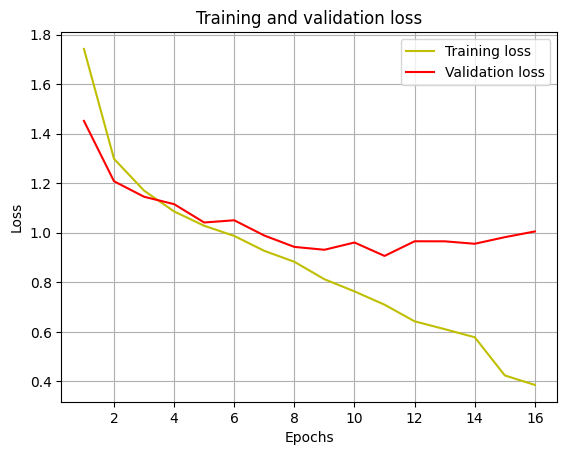

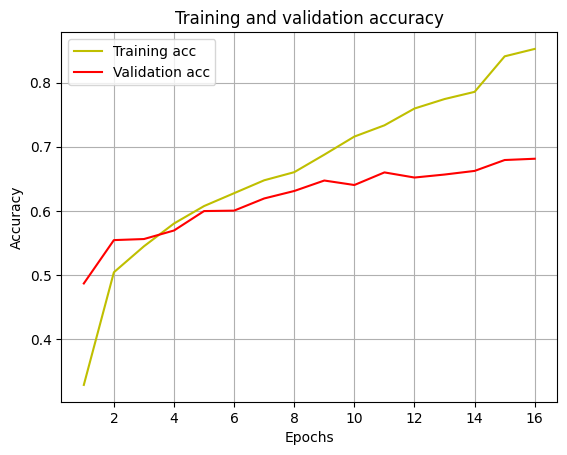

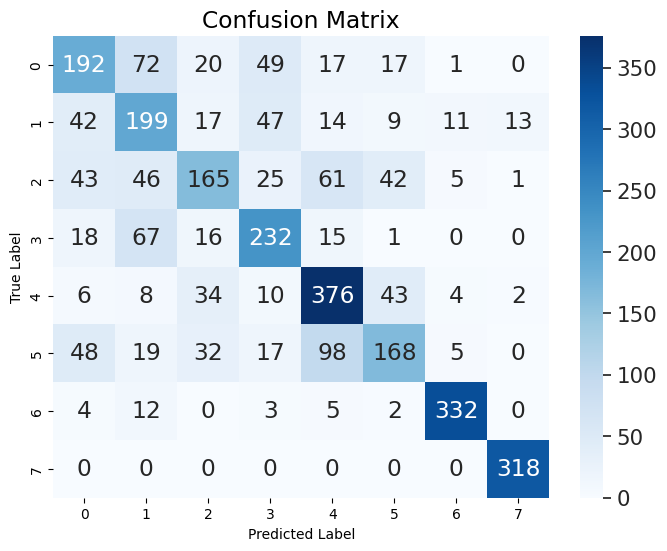

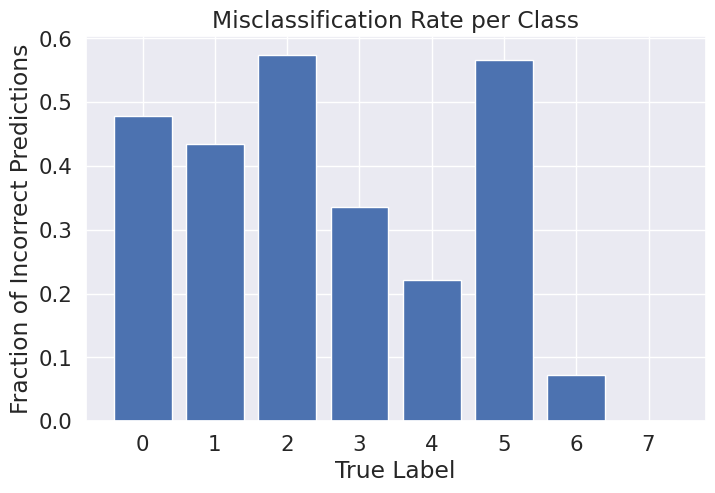

In [ ]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Step 1: Collect all predictions and true labels from the test generator
y_true = []
y_pred = []

for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    preds = model.predict(x_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 4: Plot fraction of incorrect predictions per class
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(cm)), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect Predictions')
plt.title('Misclassification Rate per Class')
plt.grid(True)
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/SequentialCNN_DualLayer2_model_66.keras')